## Описание проекта



Обучите различные модели классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества F1 не меньше 0.75.

Алгоритм решения выглядит так:
    
1. Загрузите и подготовьте данные.

2. Обучите различные модели нейронных сетей, в том числе рекуррентные.

3. Сделайте выводы.

### Описание данных

Данные находятся в файле `toxic_comments.csv`.

Столбец `text` в нём содержит текст комментария, а `toxic` — целевой признак.

## Загрузка и подготовка данных

In [ ]:
!pip install seaborn
!pip install matplotlib
!pip install pymystem3
!pip install tensorflow


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached tensorflow-2.18.0-cp312-cp312-win_amd64.whl.metadata (3.3 kB)
  Using cached tensorflow_intel-2.18.0-cp312-cp312-win_amd64.whl.metadata (4.9 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.12.23-py2.py3-none-any.whl.metadata (876 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-5.29.2-cp310-abi3-win_amd64.whl.metadata (592 bytes)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached grpcio-1.68.1-cp312-cp312-win_amd64.whl.metadata (4.0 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached keras-3.7.0-py3-none-any.whl.metadata (5.8 kB)
  Us


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pymystem3 import Mystem
import re

import numpy as np
import pandas as pd
from tqdm import notebook

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras.layers import Dense, Flatten, Dropout, Embedding, SimpleRNN, LSTM, GRU
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, RocCurveDisplay
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer


import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [ ]:
# Прочитаем файл с данными в переменную df и изучим их
try:
    from google.colab import drive
    drive.mount('/content/drive')
    df = pd.read_csv('/content/drive/My Drive/toxic_comments.csv', index_col=0)
except:
    df = pd.read_csv('toxic_comments.csv', index_col=0)

df.head(10)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [ ]:
# общая информация методом info()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Датасет состоит из 159292 записей. В столбце `text` представлен комментариями пользователей, в столбце `toxic` указана метка токсичности соответствующего высказывания.

In [ ]:
# доля пропусков
df.isnull().mean()

text     0.0
toxic    0.0
dtype: float64

In [ ]:
# число дубликатов
df.duplicated().sum()

0

Датасет не содержит пропущенных значений и явных дубликатов.

In [ ]:
# Определим количество записей каждого класса
df['toxic'].value_counts(normalize=True)

toxic
0    0.898388
1    0.101612
Name: proportion, dtype: float64

Датасет не является сбалансированным, количество объектов класса 0 значительно превышает (почти в 9 раз) количество объектов класса 1. Это как правило не приводит к высокой обощающей способности алгоритмов.

Метрика accuracy будет некорректно отражать качество классификации. В таких случаях лучше использовать `f`-меру. Для бинарной классификации оценку качества обощающей способности алгоритма также эффективно оценивать по метрике `ROC-AUC`.

Алгоритм подготовки данных для векторизации.

1. Приведём кодировку символов к `Unicode` (для русскоязычных текстов)

2. Проведём лемматизацию слов

3. Удалим пунктуацию и лишние пробелы

4. Удалим стоп-слова (пока загрузим список, удалять будем в процессе `tf-idf` векторизации)

<div class="alert alert-block alert-warning">
<b>Замечание:</b> В данном случае приводить кодировку символов к `Unicode` нет необходимости, т.к. текст на английском языке.
    Для текста на русском языке используем следующий код:
    
    corpus = df['text'].values.astype('U')
</div>


In [ ]:
corpus = df['text'].values
corpus

array(["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
       "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",
       "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",
       ...,
       'Spitzer \n\nUmm, theres no actual article for prostitution ring.  - Crunch Captain.',
       'And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.',
       '"\nAnd ... I really don\'t think you understand.  I came here and my idea was bad right away.  What kind of communit

In [ ]:
lemmatizer = WordNetLemmatizer() # Лемматизатор WordNetLemmatizer применяют к словам, а не ко всему тексту сразу

# Функция для лемматизации

def lemmatize(text):
    word_list = nltk.word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(w) for w in word_list])

In [ ]:
# Функция для устранения лишних пробелов и пунктуации
def clear_text(text):
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    return " ".join(text.split())

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [ ]:
# Проведем лемматизацию
df['lemm_text'] = [lemmatize(clear_text(corpus[i])) for i in range(len(corpus))]

In [ ]:
df['lemm_text']

0         Explanation Why the edits made under my userna...
1         D aww He match this background colour I m seem...
2         Hey man I m really not trying to edit war It s...
3         More I can t make any real suggestion on impro...
4         You sir are my hero Any chance you remember wh...
                                ...                        
159446    And for the second time of asking when your vi...
159447    You should be ashamed of yourself That is a ho...
159448    Spitzer Umm there no actual article for prosti...
159449    And it look like it wa actually you who put on...
159450    And I really don t think you understand I came...
Name: lemm_text, Length: 159292, dtype: object

In [ ]:
# сформируем список стоп-слов
stopwords = list(nltk_stopwords.words('english'))


Выделим признак и целевой признак (класс). Разделим данные на обучающую и тестовую выборки в соотношении 4:1.

In [ ]:
X = df['lemm_text']
y = df['toxic']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=145, stratify = y)

print('Размерность обучающего набора',X_train.shape)
print('Размерность тестового набора',X_test.shape)

Размерность обучающего набора (127433,)
Размерность тестового набора (31859,)


## Обучение моделей

При обучении моделей будем использовать метрику `F1`.

Сформируйте векторные представления признаков для обучения моделей. Подберите параметры алгоритмов, проведите обучение и тестирование всех построенных моделей.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

# Векторизация текста
tfidf = TfidfVectorizer(max_features=5000, stop_words=stopwords)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Модели для тестирования
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
}

# Обучение моделей и вывод метрики F1
for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    f1 = f1_score(y_test, y_pred)
    print(f'{name} F1-score: {f1:.4f}')


Logistic Regression F1-score: 0.7488
Random Forest F1-score: 0.7471
Gradient Boosting F1-score: 0.5998


## Тестирование модели

Classification Report for Logistic Regression:

              precision    recall  f1-score   support

   Non-Toxic       0.96      0.99      0.98     28622
       Toxic       0.91      0.64      0.75      3237

    accuracy                           0.96     31859
   macro avg       0.94      0.81      0.86     31859
weighted avg       0.96      0.96      0.95     31859



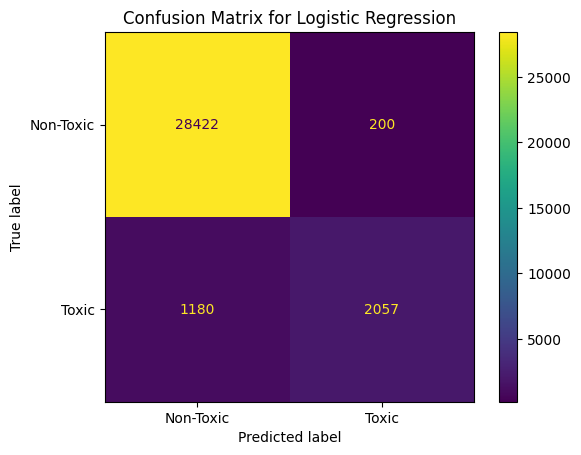

Classification Report for Random Forest:

              precision    recall  f1-score   support

   Non-Toxic       0.96      0.99      0.97     28622
       Toxic       0.84      0.66      0.74      3237

    accuracy                           0.95     31859
   macro avg       0.90      0.83      0.86     31859
weighted avg       0.95      0.95      0.95     31859



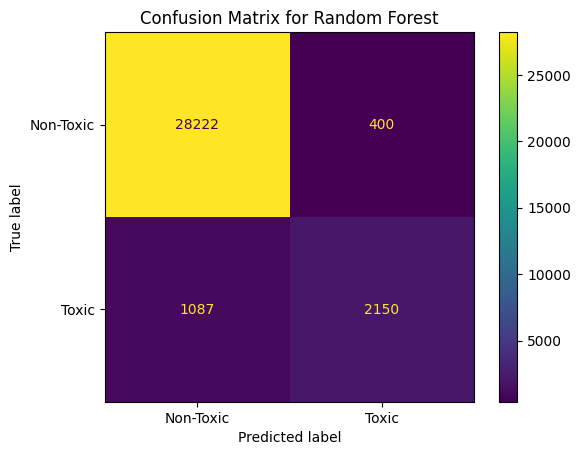

Classification Report for Gradient Boosting:

              precision    recall  f1-score   support

   Non-Toxic       0.94      1.00      0.97     28622
       Toxic       0.95      0.44      0.60      3237

    accuracy                           0.94     31859
   macro avg       0.94      0.72      0.78     31859
weighted avg       0.94      0.94      0.93     31859



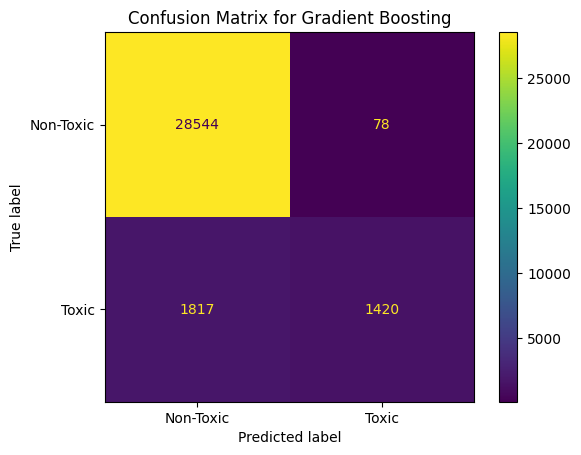

In [ ]:
# Выведем отчет о результатах классификации

from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# После предсказания
for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    # Вывод отчета о классификации
    print(f'Classification Report for {name}:\n')
    print(classification_report(y_test, y_pred, target_names=['Non-Toxic', 'Toxic']))

    # Вывод матрицы ошибок
    ConfusionMatrixDisplay.from_estimator(model, X_test_tfidf, y_test, display_labels=['Non-Toxic', 'Toxic'])
    plt.title(f'Confusion Matrix for {name}')
    plt.show()


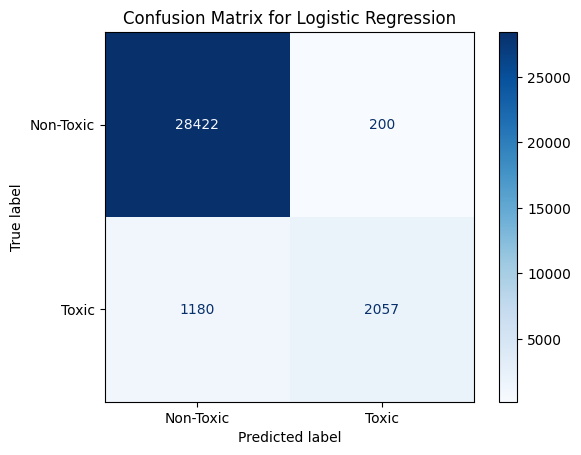

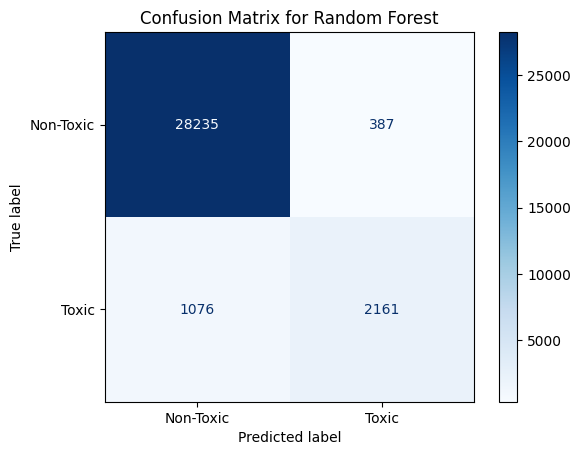

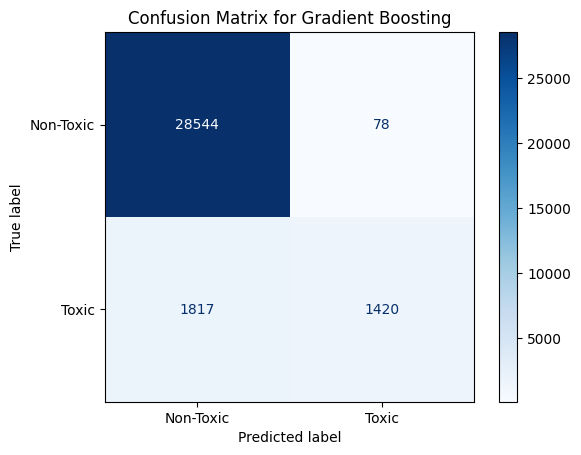

In [ ]:
# Матрица ошибок

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# После предсказания
for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    # Вычисление матрицы ошибок
    cm = confusion_matrix(y_test, y_pred)

    # Визуализация матрицы ошибок
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Toxic', 'Toxic'])

    # Построение матрицы ошибок
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {name}')
    plt.show()


Logistic Regression AUC: 0.9659
Random Forest AUC: 0.9524
Gradient Boosting AUC: 0.9041


<Figure size 1000x800 with 0 Axes>

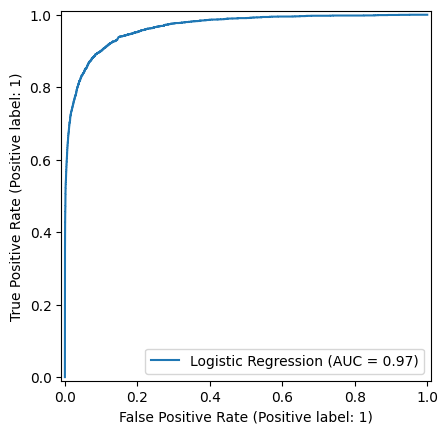

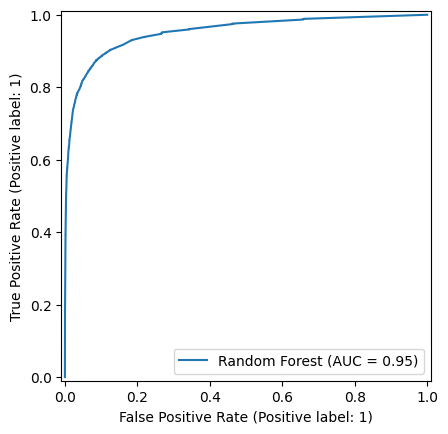

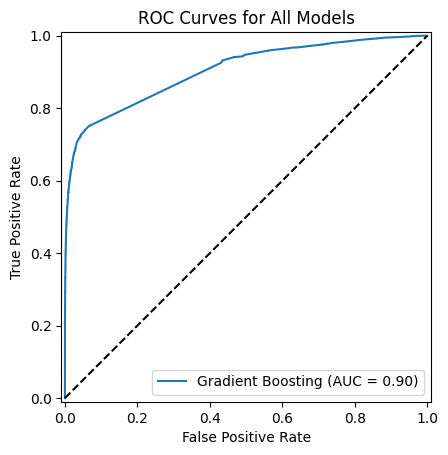

In [ ]:
# ROC-кривые построенных моделей

from sklearn.metrics import RocCurveDisplay, roc_auc_score

# Построение ROC-кривых
plt.figure(figsize=(10, 8))

for name, model in models.items():
    model.fit(X_train_tfidf, y_train)

    # Получение вероятностей принадлежности к классу 1 (токсичный)
    y_pred_proba = model.predict_proba(X_test_tfidf)[:, 1]

    # Построение ROC-кривой
    RocCurveDisplay.from_predictions(y_test, y_pred_proba, name=name)

    # Вычисление и вывод AUC
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f'{name} AUC: {auc:.4f}')

plt.plot([0, 1], [0, 1], 'k--')  # Линия наугад
plt.title('ROC Curves for All Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()


Напишите произвольные два комментария: положительный и отрицательный. Выясните, как их классифицировала Ваша модель.

In [ ]:
# Два произвольных комментария
test_comments = [
    "I love this place! Everyone is so friendly and the atmosphere is great.",  # Положительный
    "This is the worst experience I've ever had, and I hate everything about it."  # Отрицательный
]

# Преобразуем комментарии в векторное представление с помощью TF-IDF
test_comments_tfidf = tfidf.transform(test_comments)

# Используем обученную модель (например, Logistic Regression)
chosen_model = models['Logistic Regression']  # Можно выбрать любую модель

# Предсказание классов
predictions = chosen_model.predict(test_comments_tfidf)

# Отображаем результаты
for comment, prediction in zip(test_comments, predictions):
    result = "Toxic" if prediction == 1 else "Non-Toxic"
    print(f"Comment: \"{comment}\" \nPrediction: {result}\n")


Comment: "I love this place! Everyone is so friendly and the atmosphere is great." 
Prediction: Non-Toxic

Comment: "This is the worst experience I've ever had, and I hate everything about it." 
Prediction: Toxic



## Выводы

Сделайте выводы о качестве построенных моделей, о влиянии параметров алгоритмов на качество их обучения. Укажите, какая модель показала лучший результат.

In [ ]:
# Словарь для хранения метрик каждой модели
model_metrics = {}

# Цикл для обучения и оценки всех моделей
for name, model in models.items():
    # Обучение модели
    model.fit(X_train_tfidf, y_train)

    # Предсказания для тестового набора
    y_pred = model.predict(X_test_tfidf)
    y_pred_proba = model.predict_proba(X_test_tfidf)[:, 1]

    # Оценка метрик
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    # Сохранение метрик для анализа
    model_metrics[name] = {
        'F1-score': f1,
        'AUC': auc,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall
    }

    # Вывод метрик для каждой модели
    print(f"Metrics for {name}:\n"
          f"F1-score: {f1:.4f}\n"
          f"AUC: {auc:.4f}\n"
          f"Accuracy: {accuracy:.4f}\n"
          f"Precision: {precision:.4f}\n"
          f"Recall: {recall:.4f}\n")

# Анализ влияния параметров на качество модели
# Например, для логистической регрессии можно проверить изменение регуляризации
from sklearn.model_selection import GridSearchCV

param_grid_lr = {'C': [0.01, 0.1, 1, 10, 100]}  # Регуляризация для Logistic Regression
grid_lr = GridSearchCV(LogisticRegression(), param_grid_lr, scoring='f1', cv=5)
grid_lr.fit(X_train_tfidf, y_train)

# Лучшие параметры и оценка F1 на кросс-валидации
best_params_lr = grid_lr.best_params_
best_f1_lr = grid_lr.best_score_

print(f"Best parameters for Logistic Regression: {best_params_lr}")
print(f"Best F1-score for Logistic Regression on CV: {best_f1_lr:.4f}")

# Итоговые выводы
best_model = max(model_metrics, key=lambda k: model_metrics[k]['F1-score'])

print(f"The best model is: {best_model}")
print(f"Metrics for best model:\n"
      f"F1-score: {model_metrics[best_model]['F1-score']:.4f}\n"
      f"AUC: {model_metrics[best_model]['AUC']:.4f}\n"
      f"Accuracy: {model_metrics[best_model]['Accuracy']:.4f}\n"
      f"Precision: {model_metrics[best_model]['Precision']:.4f}\n"
      f"Recall: {model_metrics[best_model]['Recall']:.4f}\n")


Metrics for Logistic Regression:
F1-score: 0.7488
AUC: 0.9659
Accuracy: 0.9567
Precision: 0.9114
Recall: 0.6355

Metrics for Random Forest:
F1-score: 0.7486
AUC: 0.9531
Accuracy: 0.9542
Precision: 0.8456
Recall: 0.6716

Metrics for Gradient Boosting:
F1-score: 0.6009
AUC: 0.9047
Accuracy: 0.9406
Precision: 0.9462
Recall: 0.4402

Best parameters for Logistic Regression: {'C': 100}
Best F1-score for Logistic Regression on CV: 0.7638
The best model is: Logistic Regression
Metrics for best model:
F1-score: 0.7488
AUC: 0.9659
Accuracy: 0.9567
Precision: 0.9114
Recall: 0.6355

